In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, test_model
from utils.utils_plots import plot_first_feature_horizontal, save_figure
from utils.utils_metrics import calculate_metrics_statistics, calculate_cluster_stats, calculate_metrics, plot_confusion_matrix
import copy

In [2]:
from model.eGauss_plus import eGAUSSp

print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

feature_dim = 4
num_classes = 3

# Model parameters
local_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 3,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "N_r": 4,
    "c_max": 1000,
    "device": device
}
federated_model_params = {
    "feature_dim": feature_dim,
    "num_classes": num_classes,
    "kappa_n": 1,
    "num_sigma": 10,
    "kappa_join": 10,
    "S_0": 1e-8,
    "N_r": 4,
    "c_max": 1000,
    "device": device
}

PyTorch Version: 2.1.2
CUDA Version: 11.8
CUDA is available. Using GPU.


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 3
num_repetitions = 10

# Re-inserting the repetition of the experiment 10 times
experiment_results = []
for experiment in range(num_repetitions):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)

    # Initialize arrays to track samples per class for each client in each fold
    samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

    # Main loop for k-fold cross-validation
    all_client_metrics = [[] for _ in range(num_clients)]
    all_client_clusters = [[] for _ in range(num_clients)]

    all_federated_metrics = []
    all_federated_clusters = []

    for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
        # Split the data
        train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)

        # Create the models
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
        federated_model = eGAUSSp(**federated_model_params)

        # Train and test the models
        for client_idx, client_model in enumerate(local_models):
            # Count the number of samples per class for this client in this fold
            for class_idx in range(client_model.num_classes):
                class_samples = torch.sum((train_data[client_idx][1] == class_idx).float(), dim=0)
                samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

            # Supervised clustering
            train_supervised(client_model, train_data[client_idx])

            # Test the local models
            _, pred, _ = test_model(client_model, test_data)
            metrics = calculate_metrics(pred.cpu(), test_data, "weighted")
            all_client_metrics[client_idx].append(metrics)

            # Save the number of clusters
            num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).cpu()
            all_client_clusters[client_idx].append(num_client_clusters)

        # Aggregate local models
        for client_model in local_models:
            federated_model.federal_agent.merge_model_privately(client_model, federated_model.kappa_n, 0)
        
        aggregated_model = copy.deepcopy(federated_model)
        federated_model.federal_agent.federated_merging()
        federated_model.score = torch.ones_like(federated_model.score)
        federated_model.num_pred = torch.zeros_like(federated_model.num_pred)

        num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 0).cpu()
        all_federated_clusters.append(num_federated_clusters)

        # Test the federated model
        _, pred_fed, _ = test_model(federated_model, test_data)
        federated_metrics = calculate_metrics(pred_fed.cpu(), test_data, "weighted")
        all_federated_metrics.append(federated_metrics)

    # Store results of each experiment
    experiment_results.append({
        "client_metrics": all_client_metrics,
        "client_clusters": all_client_clusters,
        "federated_metrics": all_federated_metrics,
        "federated_clusters": all_federated_clusters,
        "samples_per_class_per_client": samples_per_class_per_client
    })
    
# Displaying the result of the first experiment for brevity
experiment_results[0]  # Replace with desired processing or analysis of experiment results


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3544, device='cuda:0')
Updated var_glo values: tensor(0.8305, device='cuda:0')
Updated var_glo values: tensor(0.7220, device='cuda:0')
Updated var_glo values: tensor(0.7102, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4935, device='cuda:0')
Updated var_glo values: tensor(0.7284, device='cuda:0')
Updated var_glo values: tensor(0.6073, device='cuda:0')
Updated var_glo values: tensor(0.6706, device='cuda:0')


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4525, device='cuda:0')
Updated var_glo values: tensor(0.6927, device='cuda:0')
Updated var_glo values: tensor(0.5875, device='cuda:0')
Updated var_glo values: tensor(0.6473, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4804, device='cuda:0')
Updated var_glo values: tensor(0.7728, device='cuda:0')
Updated var_glo values: tensor(0.7049, device='cuda:0')
Updated var_glo values: tensor(0.6862, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3351, device='cuda:0')
Updated var_glo values: tensor(0.8228, device='cuda:0')
Updated var_glo values: tensor(0.6994, device='cuda:0')
Updated var_glo values: tensor(0.6889, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4075, device='cuda:0')
Updated var_glo values: tensor(0.7522, device='cuda:0')
Updated var_glo values: tensor(0.6924, device='cuda:0')
Updated var_glo values: tensor(0.7165, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2644, device='cuda:0')
Updated var_glo values: tensor(0.5172, device='cuda:0')
Updated var_glo values: tensor(0.5982, device='cuda:0')
Updated var_glo values: tensor(0.6253, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5996, device='cuda:0')
Updated var_glo values: tensor(0.7840, device='cuda:0')
Updated var_glo values: tensor(0.6536, device='cuda:0')
Updated var_glo values: tensor(0.6626, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4234, device='cuda:0')
Updated var_glo values: tensor(0.6716, device='cuda:0')
Updated var_glo values: tensor(0.7208, device='cuda:0')
Updated var_glo values: tensor(0.7180, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3098, device='cuda:0')
Updated var_glo values: tensor(0.6423, device='cuda:0')
Updated var_glo values: tensor(0.6286, device='cuda:0')
Updated var_glo values: tensor(0.6760, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4440, device='cuda:0')
Updated var_glo values: tensor(0.7700, device='cuda:0')
Updated var_glo values: tensor(0.7107, device='cuda:0')
Updated var_glo values: tensor(0.6803, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4163, device='cuda:0')
Updated var_glo values: tensor(0.8010, device='cuda:0')
Updated var_glo values: tensor(0.7058, device='cuda:0')
Updated var_glo values: tensor(0.6713, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4771, device='cuda:0')
Updated var_glo values: tensor(0.7498, device='cuda:0')
Updated var_glo values: tensor(0.6658, device='cuda:0')
Updated var_glo values: tensor(0.6519, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4058, device='cuda:0')
Updated var_glo values: tensor(0.8137, device='cuda:0')
Updated var_glo values: tensor(0.6546, device='cuda:0')
Updated var_glo values: tensor(0.7338, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4865, device='cuda:0')
Updated var_glo values: tensor(0.6276, device='cuda:0')
Updated var_glo values: tensor(0.6725, device='cuda:0')
Updated var_glo values: tensor(0.6620, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3843, device='cuda:0')
Updated var_glo values: tensor(0.8867, device='cuda:0')
Updated var_glo values: tensor(0.7594, device='cuda:0')
Updated var_glo values: tensor(0.6956, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3383, device='cuda:0')
Updated var_glo values: tensor(0.7981, device='cuda:0')
Updated var_glo values: tensor(0.6932, device='cuda:0')
Updated var_glo values: tensor(0.6222, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4866, device='cuda:0')
Updated var_glo values: tensor(0.8260, device='cuda:0')
Updated var_glo values: tensor(0.7221, device='cuda:0')
Updated var_glo values: tensor(0.7033, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.7142, device='cuda:0')
Updated var_glo values: tensor(0.8428, device='cuda:0')
Updated var_glo values: tensor(0.7302, device='cuda:0')
Updated var_glo values: tensor(0.7026, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.1977, device='cuda:0')
Updated var_glo values: tensor(0.6868, device='cuda:0')
Updated var_glo values: tensor(0.6231, device='cuda:0')
Updated var_glo values: tensor(0.6713, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5895, device='cuda:0')
Updated var_glo values: tensor(0.8513, device='cuda:0')
Updated var_glo values: tensor(0.7963, device='cuda:0')
Updated var_glo values: tensor(0.7270, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5665, device='cuda:0')
Updated var_glo values: tensor(0.8811, device='cuda:0')
Updated var_glo values: tensor(0.7253, device='cuda:0')
Updated var_glo values: tensor(0.7200, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4433, device='cuda:0')
Updated var_glo values: tensor(0.7396, device='cuda:0')
Updated var_glo values: tensor(0.6293, device='cuda:0')
Updated var_glo values: tensor(0.6274, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3793, device='cuda:0')
Updated var_glo values: tensor(0.6135, device='cuda:0')
Updated var_glo values: tensor(0.6282, device='cuda:0')
Updated var_glo values: tensor(0.6697, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4395, device='cuda:0')
Updated var_glo values: tensor(0.7557, device='cuda:0')
Updated var_glo values: tensor(0.6744, device='cuda:0')
Updated var_glo values: tensor(0.6595, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5517, device='cuda:0')
Updated var_glo values: tensor(0.7507, device='cuda:0')
Updated var_glo values: tensor(0.6156, device='cuda:0')
Updated var_glo values: tensor(0.6883, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4511, device='cuda:0')
Updated var_glo values: tensor(0.7357, device='cuda:0')
Updated var_glo values: tensor(0.7144, device='cuda:0')
Updated var_glo values: tensor(0.7290, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3626, device='cuda:0')
Updated var_glo values: tensor(0.7871, device='cuda:0')
Updated var_glo values: tensor(0.6296, device='cuda:0')
Updated var_glo values: tensor(0.6810, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4511, device='cuda:0')
Updated var_glo values: tensor(0.7475, device='cuda:0')
Updated var_glo values: tensor(0.6208, device='cuda:0')
Updated var_glo values: tensor(0.6732, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3291, device='cuda:0')
Updated var_glo values: tensor(0.7248, device='cuda:0')
Updated var_glo values: tensor(0.5997, device='cuda:0')
Updated var_glo values: tensor(0.6315, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3140, device='cuda:0')
Updated var_glo values: tensor(0.7103, device='cuda:0')
Updated var_glo values: tensor(0.6410, device='cuda:0')
Updated var_glo values: tensor(0.6617, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5040, device='cuda:0')
Updated var_glo values: tensor(0.9247, device='cuda:0')
Updated var_glo values: tensor(0.7738, device='cuda:0')
Updated var_glo values: tensor(0.7706, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5587, device='cuda:0')
Updated var_glo values: tensor(0.7227, device='cuda:0')
Updated var_glo values: tensor(0.6224, device='cuda:0')
Updated var_glo values: tensor(0.6330, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4566, device='cuda:0')
Updated var_glo values: tensor(0.9572, device='cuda:0')
Updated var_glo values: tensor(0.7651, device='cuda:0')
Updated var_glo values: tensor(0.7108, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4231, device='cuda:0')
Updated var_glo values: tensor(0.6862, device='cuda:0')
Updated var_glo values: tensor(0.5649, device='cuda:0')
Updated var_glo values: tensor(0.6252, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5317, device='cuda:0')
Updated var_glo values: tensor(0.7528, device='cuda:0')
Updated var_glo values: tensor(0.7151, device='cuda:0')
Updated var_glo values: tensor(0.6687, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3518, device='cuda:0')
Updated var_glo values: tensor(0.8069, device='cuda:0')
Updated var_glo values: tensor(0.6969, device='cuda:0')
Updated var_glo values: tensor(0.7177, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.1796, device='cuda:0')
Updated var_glo values: tensor(0.7509, device='cuda:0')
Updated var_glo values: tensor(0.7333, device='cuda:0')
Updated var_glo values: tensor(0.6607, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3554, device='cuda:0')
Updated var_glo values: tensor(0.7969, device='cuda:0')
Updated var_glo values: tensor(0.7006, device='cuda:0')
Updated var_glo values: tensor(0.7054, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2674, device='cuda:0')
Updated var_glo values: tensor(0.7395, device='cuda:0')
Updated var_glo values: tensor(0.6502, device='cuda:0')
Updated var_glo values: tensor(0.6489, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.6639, device='cuda:0')
Updated var_glo values: tensor(0.8072, device='cuda:0')
Updated var_glo values: tensor(0.5821, device='cuda:0')
Updated var_glo values: tensor(0.6387, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4961, device='cuda:0')
Updated var_glo values: tensor(0.9125, device='cuda:0')
Updated var_glo values: tensor(0.7335, device='cuda:0')
Updated var_glo values: tensor(0.7172, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3352, device='cuda:0')
Updated var_glo values: tensor(0.9093, device='cuda:0')
Updated var_glo values: tensor(0.7387, device='cuda:0')
Updated var_glo values: tensor(0.6710, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5009, device='cuda:0')
Updated var_glo values: tensor(0.8391, device='cuda:0')
Updated var_glo values: tensor(0.6523, device='cuda:0')
Updated var_glo values: tensor(0.7081, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.5559, device='cuda:0')
Updated var_glo values: tensor(0.9052, device='cuda:0')
Updated var_glo values: tensor(0.7146, device='cuda:0')
Updated var_glo values: tensor(0.6655, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4283, device='cuda:0')
Updated var_glo values: tensor(0.8141, device='cuda:0')
Updated var_glo values: tensor(0.6936, device='cuda:0')
Updated var_glo values: tensor(0.7208, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.4344, device='cuda:0')
Updated var_glo values: tensor(0.8018, device='cuda:0')
Updated var_glo values: tensor(0.6493, device='cuda:0')
Updated var_glo values: tensor(0.6989, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3112, device='cuda:0')
Updated var_glo values: tensor(0.8221, device='cuda:0')
Updated var_glo values: tensor(0.6609, device='cuda:0')
Updated var_glo values: tensor(0.7086, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.3030, device='cuda:0')
Updated var_glo values: tensor(0.6257, device='cuda:0')
Updated var_glo values: tensor(0.6054, device='cuda:0')
Updated var_glo values: tensor(0.6152, device='cuda:0')
Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.


c:\Users\Miha\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evolving has been disabled.
Evolving has been enabled.
Evolving has been disabled.
Updated var_glo values: tensor(0.2820, device='cuda:0')
Updated var_glo values: tensor(0.7248, device='cuda:0')
Updated var_glo values: tensor(0.6748, device='cuda:0')
Updated var_glo values: tensor(0.6615, device='cuda:0')
Evolving has been disabled.


{'client_metrics': [[{'accuracy': 0.7,
    'precision': 0.5893939393939395,
    'recall': 0.7,
    'f1_score': 0.6182010582010583},
   {'accuracy': 0.5,
    'precision': 0.315,
    'recall': 0.5,
    'f1_score': 0.38636363636363635},
   {'accuracy': 0.43333333333333335,
    'precision': 0.4371794871794872,
    'recall': 0.43333333333333335,
    'f1_score': 0.34476190476190477},
   {'accuracy': 0.5666666666666667,
    'precision': 0.4138888888888888,
    'recall': 0.5666666666666667,
    'f1_score': 0.4627246376811594},
   {'accuracy': 0.6,
    'precision': 0.5399999999999999,
    'recall': 0.6,
    'f1_score': 0.529192546583851}],
  [{'accuracy': 0.5666666666666667,
    'precision': 0.3782608695652174,
    'recall': 0.5666666666666667,
    'f1_score': 0.4353535353535353},
   {'accuracy': 0.5666666666666667,
    'precision': 0.4298245614035088,
    'recall': 0.5666666666666667,
    'f1_score': 0.4626666666666666},
   {'accuracy': 0.7,
    'precision': 0.5212962962962963,
    'recall': 0

In [4]:
import numpy as np

# Initialize variables to store aggregated data
agg_client_metrics = [{} for _ in range(num_clients)]
agg_federated_metrics = {}
agg_client_clusters = [[] for _ in range(num_clients)]
agg_federated_clusters = []

# Process each experiment
for result in experiment_results:
    for client_idx, client_metrics in enumerate(result['client_metrics']):
        for metric in client_metrics[0].keys():
            if metric not in agg_client_metrics[client_idx]:
                agg_client_metrics[client_idx][metric] = []
            agg_client_metrics[client_idx][metric].extend([m[metric] for m in client_metrics])

    for metric in result['federated_metrics'][0].keys():
        if metric not in agg_federated_metrics:
            agg_federated_metrics[metric] = []
        agg_federated_metrics[metric].extend([m[metric] for m in result['federated_metrics']])

    for client_idx, client_clusters in enumerate(result['client_clusters']):
        agg_client_clusters[client_idx].extend(client_clusters)

    agg_federated_clusters.extend(result['federated_clusters'])

# Calculate averages and standard deviations
for client_metrics in agg_client_metrics:
    for metric, values in client_metrics.items():
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        client_metrics[metric] = (mean, std)

for metric, values in agg_federated_metrics.items():
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    agg_federated_metrics[metric] = (mean, std)

# Example of printing aggregated metrics for the first client
print("Aggregated Metrics for Client 1:")
for metric, (mean, std) in agg_client_metrics[0].items():
    print(f"{metric}: {mean:.2f} ± {std:.2f}")

agg_samples = np.zeros((num_clients, num_classes, num_splits))

# Aggregate data from each experiment
for result in experiment_results:
    samples_per_class_per_client = result['samples_per_class_per_client']
    agg_samples += samples_per_class_per_client

# Compute the average across all repetitions (and folds if required)
avg_samples = agg_samples / len(experiment_results)

# Calculate the average for each client and class across folds
avg_samples_per_class_per_client = avg_samples.mean(axis=2)

# Print the results
for client_idx in range(num_clients):
    print(f"Client {client_idx + 1}:")
    for class_idx in range(num_classes):
        avg_samples = avg_samples_per_class_per_client[client_idx, class_idx]
        print(f"  Class {class_idx}: {avg_samples:.2f} samples")

Aggregated Metrics for Client 1:
accuracy: 0.58 ± 0.08
precision: 0.45 ± 0.08
recall: 0.58 ± 0.08
f1_score: 0.48 ± 0.09
Client 1:
  Class 0: 0.00 samples
  Class 1: 9.72 samples
  Class 2: 10.60 samples
Client 2:
  Class 0: 19.92 samples
  Class 1: 0.00 samples
  Class 2: 9.68 samples
Client 3:
  Class 0: 9.88 samples
  Class 1: 20.34 samples
  Class 2: 9.86 samples
Client 4:
  Class 0: 10.20 samples
  Class 1: 9.94 samples
  Class 2: 9.86 samples


In [11]:
# Create a LaTeX table for the paper
# Start the LaTeX table code
latex_table = r"""\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
"""

# Add the header for average samples per class
latex_table += r"Average Samples"

# Add the average samples per class for each client
samples_row = ""
for samples in avg_samples_per_class_per_client:
    samples_row += " & " + "/".join([f"{x:.1f}" for x in samples])
latex_table += samples_row + " \\\\" + "\n"

latex_table += r"\midrule" + "\n"


# Add rows for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['Accuracy (\%)', 'Precision (\%)', 'Recall (\%)', 'F1 Score (\%)']
for i, metric in enumerate(metrics):
    row = metric_names[i] + r' $\uparrow$'
    for client_metrics in agg_client_metrics:
        mean, std = client_metrics[metric]
        row += f' & {mean * 100:.1f} ± {std * 100:.1f}'
    mean, std = agg_federated_metrics[metric]
    row += r' & \bf' + f'{{{mean * 100:.1f} ± {std * 100:.1f}}}'
    latex_table += row + r' \\' + '\n'

# Add row for clusters
cluster_row = r'\#Clusters $\downarrow$'
for client_clusters in agg_client_clusters:
    avg_clusters = np.mean(client_clusters)
    std_clusters = np.std(client_clusters, ddof=1)
    cluster_row += f' & {avg_clusters:.1f} ± {std_clusters:.1f}'

# Assuming agg_federated_clusters is a list of cluster counts for the federated model
avg_fed_clusters = np.mean(agg_federated_clusters)
std_fed_clusters = np.std(agg_federated_clusters, ddof=1)
cluster_row += r' & \bf' + f'{{{avg_fed_clusters:.1f} ± {std_fed_clusters:.1f}}}'

latex_table += cluster_row + r' \\' + '\n'

# End the LaTeX table code
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the complete LaTeX table
print(latex_table)


\begin{table}[ht]
\centering
\setlength{\tabcolsep}{2pt}
\scriptsize
\caption{Performance metrics and average number of clusters on the Iris dataset.}
\label{tab:performance_clusters}
\begin{tabular}{lcccccc}
\toprule
\textbf{Metric} & \textbf{Client 1} & \textbf{Client 2} & \textbf{Client 3} & \textbf{Client 4} & \textbf{Federated} \\
Average Samples & 0.0/9.7/10.6 & 19.9/0.0/9.7 & 9.9/20.3/9.9 & 10.2/9.9/9.9 \\
\midrule
Accuracy (\%) $\uparrow$ & 58.1 ± 8.4 & 66.2 ± 8.2 & 88.1 ± 6.2 & 85.4 ± 9.1 & \bf{96.5 ± 3.0} \\
Precision (\%) $\uparrow$ & 44.6 ± 8.5 & 49.5 ± 9.4 & 91.1 ± 4.4 & 87.1 ± 10.3 & \bf{96.9 ± 2.5} \\
Recall (\%) $\uparrow$ & 58.1 ± 8.4 & 66.2 ± 8.2 & 88.1 ± 6.2 & 85.4 ± 9.1 & \bf{96.5 ± 3.0} \\
F1 Score (\%) $\uparrow$ & 48.5 ± 8.6 & 55.2 ± 9.4 & 87.7 ± 6.9 & 84.4 ± 10.7 & \bf{96.4 ± 3.0} \\
\#Clusters $\downarrow$ & 4.8 ± 1.2 & 2.7 ± 0.8 & 4.3 ± 1.0 & 4.6 ± 1.2 & \bf{3.0 ± 0.0} \\
\bottomrule
\end{tabular}
\end{table}



Client 1: {1: 9, 2: 13}
Client 2: {0: 19, 2: 12}
Client 3: {0: 11, 1: 18, 2: 8}
Client 4: {0: 10, 1: 9, 2: 11}
Test Set: {0: 10, 1: 14, 2: 6}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as .Images/iris_data_distribution.svg in svg format.


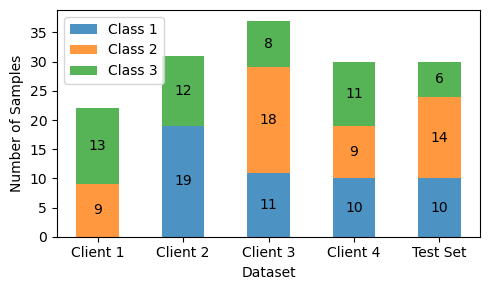

In [6]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, ".Images/iris_data_distribution.svg","svg")

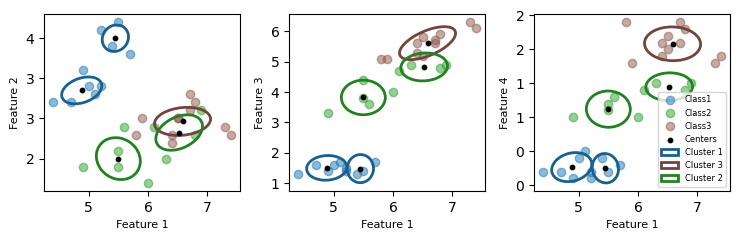

Figure saved as .Images/iris_local_model.svg in svg format.
Figure saved as .Images/iris_local_model.pdf in pdf format.


In [7]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="",format='%d', legend = True, data_name = "Class")  
save_figure(fig, ".Images/iris_local_model.svg", "svg")
save_figure(fig, ".Images/iris_local_model.pdf","pdf")

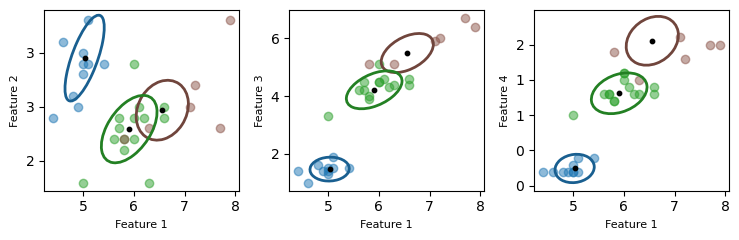

Number of clusters after merging = 3
Figure saved as .Images/iris_federated_merged.svg in svg format.
Figure saved as .Images/iris_federated_merged.pdf in pdf format.


In [8]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, ".Images/iris_federated_merged.svg","svg")
save_figure(fig, ".Images/iris_federated_merged.pdf","pdf")

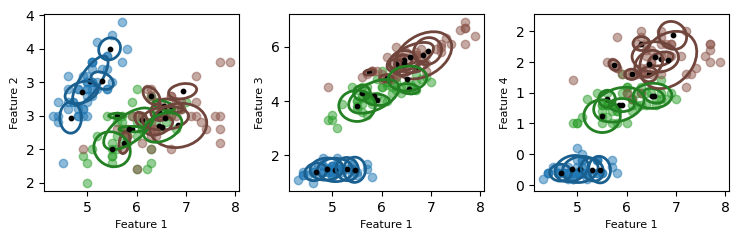

Figure saved as .Images/iris_aggregated.svg in svg format.
Figure saved as .Images/iris_aggregated.pdf in pdf format.


In [9]:
#Plot of the last aggregated model
fig = plot_first_feature_horizontal(all_data, model= aggregated_model.cpu(), num_sigma=2, N_max=0, title="", format='%d')   
save_figure(fig, ".Images/iris_aggregated.svg","svg")
save_figure(fig, ".Images/iris_aggregated.pdf","pdf")

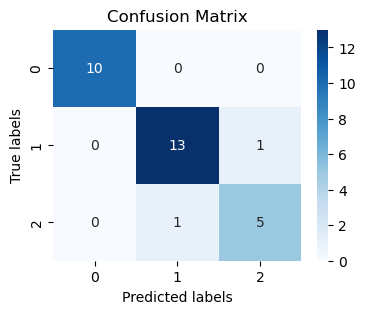

In [10]:
plot_confusion_matrix(pred_fed.cpu(), test_data)